<a href="https://colab.research.google.com/github/PaoloGerosa/Chemotherapy-Associated-Liver-Injury/blob/main/Cali_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting 


In [ ]:
# mount "mnt" if you need to upload packages from Google Drive, otherwise mount "drive" --> more stable
from google.colab import drive
drive.mount._DEBUG = True
drive.mount("mnt", force_remount=True)
%cd "/content/mnt/My Drive/Project_X"

# Upload Packages

In [ ]:
#Install packages not already in Colab

!pip install scikit-image==0.18.1
!pip install --upgrade plotly
!pip install IMED
!pip install import_ipynb
!pip install scikit-learn_extra
!pip install statsmodels

In [ ]:
# Colab settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# General libraries
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import io
import math
import time
import scipy.io as sio
import IMED

# Graphical tools libraries 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px 
import statsmodels.api as sm

# Clustering algorithm from scikit-learn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN

# Internal libraries
import import_ipynb
import Graph
import Kernel
import Distances
import Clustering
import Add_column

# Load Raw Data

In [ ]:
# Function to change Threshold that consider a patient with CALI (>= Threshold) or without CALI (< Threshold)

def change_threshold(thresh):
  outcome_dataset["CALI"] = None
  for index in outcome_dataset.index:
    count = flag = 0
    for col in outcome_dataset.columns:
      if col != "CALI":
        if outcome_dataset.loc[index][col] is None:
          flag = 1 
        elif outcome_dataset.loc[index][col]:
          count += 1
    if count >= thresh:
      outcome_dataset.at[index, "CALI"] = 1
    elif count >= 0 and count < thresh -1:
      outcome_dataset.at[index,"CALI"] = 0
    elif not flag:
        outcome_dataset.at[index, "CALI"] = 0

In [ ]:
# Load raw data
# patients_aux is a set of all the patients ID
# outcome_dataset is a dataframe with all the CALIs for the patient (patient is the index)
# no_cali and all_cali are lists that save the patients with 0 CALI and with >= 6 CALIs

dataset = pd.read_json('/content/mnt/MyDrive/Project_X/Data/volumes.json')
patients = dataset['Patient_ID'] #125 of the patients that has a volume
patients_aux = set(patients)
volumes = dataset.set_index('Patient_ID')

outcome_dataset = pd.read_excel('/content/mnt/MyDrive/Project_X/Data/Database_CALI.xlsx')[['CODE-ID', 'SOS', 'Fibrosis perisinusoidal', 'Fibrosis centrolobular', 'Peliosis', 'NRH', 'Steatosis', 'Lobular flogosis', 'Balooning', 'Steatohepatitis']].set_index('CODE-ID')
dataset = dataset.set_index('Patient_ID')
whole_data = pd.read_excel('/content/mnt/MyDrive/Project_X/Data/Database_CALI.xlsx').set_index('CODE-ID')
outcome_dataset["CALI"] = None
threshold = 1

alternative_columns = ['SOS', 'NRH', 'Steatosis', 'Lobular flogosis', 'Balooning']
columns = ['Fibrosis perisinusoidal', 'Fibrosis centrolobular', 'Peliosis', 'Steatohepatitis']
for index in outcome_dataset.index:
  if index not in patients_aux:
    outcome_dataset = outcome_dataset.drop(index)
  else:
    count = 0
    flag = 0
    for col in alternative_columns:
      if outcome_dataset.loc[index][col] in [2, 3]:
        outcome_dataset.at[index, col] = 1
        count += 1
      elif not outcome_dataset.loc[index][col].is_integer():
        flag = 1
      else:
        outcome_dataset.at[index, col] = 0
    for col in columns:
      if not outcome_dataset.loc[index][col].is_integer():
        flag = 1
      elif outcome_dataset.loc[index][col]:
        count += 1
    if count >= threshold:
      outcome_dataset.at[index, "CALI"] = 1
    elif not flag:
      outcome_dataset.at[index, "CALI"] = 0

patients_index = outcome_dataset.index #120 indices of the patients in the dataset
patients_index_aux = set(patients_index)

outcome_dataset = outcome_dataset.where(pd.notnull(outcome_dataset), None)
no_cali = outcome_dataset.index[outcome_dataset['CALI'] == 0].tolist()
change_threshold(6)
all_cali = outcome_dataset.index[outcome_dataset['CALI'] == 1].tolist()
change_threshold(3)

print("Size of the dataset (row, col): ", volumes.shape)
print("\nFirst 5 rows\n", volumes.head(n=5))

In [ ]:
# whole data is used in "Clustering" and it is already available in "Data_NoCali_SPS"

# whole_data = pd.read_excel('/content/mnt/MyDrive/Project_X/Data/Database_CALI.xlsx').set_index('CODE-ID')
# whole_data = whole_data.where(pd.notnull(whole_data), None)
# whole_data.to_excel('/content/mnt/MyDrive/Project_X/Data_NoCali_SPS/whole_data.xlsx')

In [ ]:
# add column on excel file with: 2 if CALI >= 4
#                                0 if CALI = 0
#                                1 else 
# column already added in "Database_modificato" in "ANOVA_MANOVA_IntermediatePresentation", no need to re-run 

# change_threshold(4)
# temp = outcome_dataset.copy(deep = True)
# temp['GROUPS'] = 'NaN'
# for index, row in outcome_dataset.iterrows():
#  if row['CALI'] == 1:
#    temp['GROUPS'][index] = 2
#  elif row['CALI'] == 0:
#    temp['GROUPS'][index] = 1

# change_threshold(1)
# for index, row in outcome_dataset.iterrows():
#  if row['CALI'] == 0:
#    temp['GROUPS'][index] = 0

# Add_column.add_column(temp['GROUPS'],'GROUPS',patients_aux)
# print(outcome_dataset)


In [ ]:
# Adding columns to dataframe

outcome_dataset["Combo_Steatohepat-Pelios-SOS"] = None
#outcome_dataset["Combo_SOS-Fibrosis"] = None
#outcome_dataset.drop("Combo_SOS-Fibrosis", axis = 1, inplace = True)
outcome_dataset["Combo_NoCali-ComboSPS"] = None
outcome_dataset["Combo_NoCali-NRH"] = None
outcome_dataset["Combo_NoCali-ComboSP"] = None
outcome_dataset["Combo_NoCali-ComboNSOP"] = None
outcome_dataset["Combo_NoCali-SOS"] = None
outcome_dataset["Combo_NoCali-Peliosis"] = None


combo_id = []

for index in outcome_dataset.index:
  if not (outcome_dataset.loc[index]["SOS"] is None and outcome_dataset.loc[index]["Peliosis"] is None and outcome_dataset.loc[index]["Steatohepatitis"] is None):
    if outcome_dataset.loc[index]["SOS"] and (outcome_dataset.loc[index]["Peliosis"] or outcome_dataset.loc[index]["Steatohepatitis"]):
      outcome_dataset.at[index, "Combo_Steatohepat-Pelios-SOS"] = 1
      combo_id.append(index)
    elif outcome_dataset.loc[index]["SOS"] == 0 or (outcome_dataset.loc[index]["Peliosis"] == 0 and outcome_dataset.loc[index]["Steatohepatitis"] == 0):
      outcome_dataset.at[index, "Combo_Steatohepat-Pelios-SOS"] = 0

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-ComboSPS"] = 0
  elif outcome_dataset.loc[index]["Combo_Steatohepat-Pelios-SOS"]:
    outcome_dataset.at[index, "Combo_NoCali-ComboSPS"] = 1

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-NRH"] = 0
  elif outcome_dataset.loc[index]["NRH"]:
    outcome_dataset.at[index, "Combo_NoCali-NRH"] = 1

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-ComboSP"] = 0
  elif outcome_dataset.loc[index]["Peliosis"] or outcome_dataset.loc[index]["Steatohepatitis"]:
    outcome_dataset.at[index, "Combo_NoCali-ComboSP"] = 1

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-ComboNSOP"] = 0
  elif outcome_dataset.loc[index]["SOS"] and ( outcome_dataset.loc[index]["Peliosis"] or outcome_dataset.loc[index]["NRH"] ):
    outcome_dataset.at[index, "Combo_NoCali-ComboNSOP"] = 1

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-SOS"] = 0
  elif outcome_dataset.loc[index]["SOS"]:
    outcome_dataset.at[index, "Combo_NoCali-SOS"] = 1

for index in outcome_dataset.index:
  if index in no_cali:
    outcome_dataset.at[index, "Combo_NoCali-Peliosis"] = 0
  elif outcome_dataset.loc[index]["Peliosis"]:
    outcome_dataset.at[index, "Combo_NoCali-Peliosis"] = 1





In [ ]:
outcome_dataset

# Kernel

In [ ]:
# Create Filters of volumes

filter_dim = 3
stat_features , filters_entropy, stat_quantities, histograms, second_histograms = Kernel.make_filters(dataset, filter_dim)

'''
	stat_features: dataframe containing, for each patient
	- Median filter
	- Dispersion
  - Max Min
  - Abs Diff
  - Mean
  - Autocorrelation
  - Sobel
  - Laplace
  - Prewitt
  - Global entropy
  - Local entropy

  filters entropy: dataframe containing, for each patient and for each filter, the global entropy of the filter

  stat_quantities: Mean, Variance of each volume

  histograms: histograms for the volumes and for each filter. 
  - Volumes
  - Histogram statistics
	- Median filter
	- Dispersion
  - Max Min
  - Abs Diff
  - Mean
  - Autocorrelation
  - Sobel
  - Laplace
  - Prewitt

  EX histograms['Sobel'] gives the histograms for the Sobel filters of all the patients
  
  second_histograms: second order histograms for the volumes and for each filter. 
  - Volumes
	- Median filter
	- Dispersion
  - Max Min
  - Abs Diff
  - Mean
  - Autocorrelation
  - Sobel
  - Laplace
  - Prewitt
  
  EX second_histograms['Sobel'] gives the second order histograms for the Sobel filters of all the patients

  
''' 

"\n\tstat_features: dataframe containing, for each patient\n\t- Median filter\n\t- Dispersion\n  - Max Min\n  - Abs Diff\n  - Mean\n  - Autocorrelation\n  - Sobel\n  - Laplace\n  - Prewitt\n  - Global entropy\n  - Local entropy\n\n  filters entropy: dataframe containing, for each patient and for each filter, the global entropy of the filter\n\n  stat_quantities: Mean, Variance of each volume\n\n  histograms: histograms for the volumes and for each filter. \n  - Volumes\n  - Histogram statistics\n\t- Median filter\n\t- Dispersion\n  - Max Min\n  - Abs Diff\n  - Mean\n  - Autocorrelation\n  - Sobel\n  - Laplace\n  - Prewitt\n\n  EX histograms['Sobel'] gives the histograms for the Sobel filters of all the patients\n  \n  second_histograms: second order histograms for the volumes and for each filter. \n  - Volumes\n\t- Median filter\n\t- Dispersion\n  - Max Min\n  - Abs Diff\n  - Mean\n  - Autocorrelation\n  - Sobel\n  - Laplace\n  - Prewitt\n  \n  EX second_histograms['Sobel'] gives the s

In [ ]:
#Visualize Filters

#stat_features.head()
stat_features['Global entropy'][122]

4.601588791533243

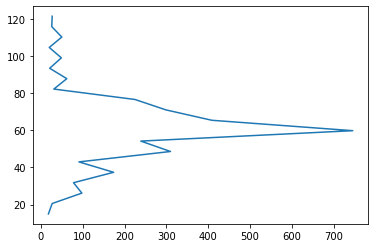

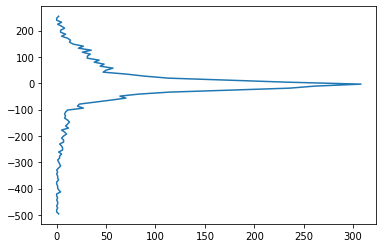

In [ ]:
#Visualize histograms (frequency - pixel's value)

hist = histograms['Volumes'][1]
Graph.plot_hist(hist)

second_hist = second_histograms['Sobel'][1]
Graph.plot_hist(second_hist)

# Graphic Representation

In [ ]:
## Graph.plot_3D can take 1 or 3 arguments in input
## For both type the first input is the volume, access to it using volumes.loc[patient_ID]['VOI]
## in the second case you give in input also isomin and isomax for the colour range for the graph

## Graph.plot_slices takes in input only the volume and plot an interactive graph
## of all the slices of the volume

In [ ]:
for index in no_cali:
  if index in volumes.index:
    Graph.plot_3D(np.array(volumes.loc[index]['VOI']).T, 0, 127, index)

In [ ]:
for index in combo_id:
  if index in volumes.index:
    Graph.plot_3D(np.array(volumes.loc[index]['VOI']).T, 0, 127, index)

# Clustering


In [ ]:
## For each block there is a Clustering technique applied to the volumes
## volumes can be the raw ones or the ones after creating the filters.
## Distances used for clustering: Euclidean, Absolute between entropy, IMED, SIFT

# Silhouette Analysis prints, given the true labels and the predictide labels, 
# the value of the Silhouette function for each k in {2, 3, 4, 5, 6, 7}

# clustering_score is a function used to compute a dataframe. If number of inputs is 2 
# (outcome_dataset, predictive labels) the columns are
# the type of CALI and which rows are the predictive labels --> the value of the cells
# represent the number of patients belonging to group i that have CALI j.
# If number of inputs is 3 (outcome_dataset, predictive labels, type of CALI)
# then it simply gives the confusion matrix of the CALI given in input

# score_relative takes in input outcome_dataset, the dataframe of clustering_score
# with 2 inputs and the predictide labels and gives in output a dataframe representing 
# the relative frequency of a CALI wrt the total number of patients in the group

# clust_methods computes the Clustering labels given the distance matrix, the type
# of clustering technique and the number of clusters to be used

# confusion_matrix takes in input the outcome_dataset and the predictide labels
# and gives in output the confusion matrix using the CALI column of the outcome_dataframe

## ['SOS', 'Fibrosis perisinusoidal', 'Fibrosis centrolobular', 'Peliosis', 'NRH', 'Steatosis', 'Lobular flogosis', 'Balooning', 'Steatohepatitis']

In [ ]:
### Standard for Clustering --> difficult part is to exctact distance matrix

# Clustering --- Global Entropy of each Filter --- Absolute Distance
'''
filters_entropy = filters_entropy.T

for col in filters_entropy.columns:
  print(col)
  dist = Distances.get_abs_dist(filters_entropy[col])

  Agg_labels = Clustering.clust_methods(dist,"Agglomerative", 2)
  Kmed_labels = Clustering.clust_methods(dist, "Kmedoids", 2)
  print(Agg_labels)
  num_1_Agg = np.sum(Agg_labels)
  print ("number of 1's: ", num_1_Agg)
  print(Kmed_labels)
  num_1_Kmed = np.sum(Kmed_labels)
  print ("number of 1's: ", num_1_Kmed)

  #Silhouette Analysis
  Clustering.Silhouette_Analysis(dist,"Kmedoids")
  Clustering.Silhouette_Analysis(dist,"Agglomerative")
  
  #Matrix with absolute frequencies (Agglomerative clustering)
  matrix1 = Clustering.clustering_score(outcome_dataset, Agg_labels)
  print('\033[1m' + "\nAbsolute values Agglomerative Clustering:" + '\033[0m')
  print(matrix1)
  #Matrix with relative frequencies
  matrix1_rel = Clustering.score_relative(outcome_dataset, matrix1, num_1_Agg)
  print('\033[1m' + "\nRelative values Agglomerative Clustering:" + '\033[0m')
  print(matrix1_rel)

  #Matrix with absolute frequencies (Kmedoids clustering)
  matrix2 = Clustering.clustering_score(outcome_dataset, Kmed_labels)
  print('\033[1m' + "\nAbsolute values Kmedoids Clustering:" + '\033[0m')
  print(matrix2)
  #Matrix with relative frequencies
  matrix2_rel = Clustering.score_relative(outcome_dataset, matrix2, num_1_Kmed)
  print('\033[1m' + "\nRelative values Kmedoids Clustering:" + '\033[0m')
  print(matrix2_rel)
    
  print("--------------------------------------------")
  print("--------------------------------------------")
'''

# Clustering --- Volumes after filter transformation --- Euclidean Distance
'''
for col in stat_features.columns[:9]:
  print('\033[94m' + '\033[1m' + col + '\033[0m')
  dist = Distances.get_eucl_dist(stat_features[col])
    
  print("--------------------------------------------")
  print("--------------------------------------------")
'''


# Clustering --- Global entropy of raw volumes --- Absolute Distance
'''
print('\033[94m' + '\033[1m' + 'Global entropy' + '\033[0m')
dist = Distances.get_abs_dist(stat_features['Global entropy'])
'''


# Kmedoids Clustering --- Volumes after filter transformation --- IMED
'''
for col in stat_features.columns[:9]:
  print(col)
  dist = Distances.get_IMED_dist(stat_features[col])
  
  print("--------------------------------------------")
  print("--------------------------------------------")
'''


# Kmedoids Clustering --- Raw Volumes --- IMED
'''
print('\033[94m' + '\033[1m' + 'IMED' + '\033[0m')
dist_IMED = Distances.get_IMED_dist(volumes['VOI'])
'''


# Kmedoids Clustering --- Raw Volumes --- SIFT
'''
print('\033[94m' + '\033[1m' + 'Sift' + '\033[0m')
dist_SIFT = Distances.get_sift_dist()
'''


# Kmedoids Clustering --- Histograms --- Wasserstein Distance
'''
print('\033[94m' + '\033[1m' + 'Histograms' + '\033[0m')
dist_hist=Distances.hist_dist(histograms['Dispersion'])
'''


# Representation of confusion matrix:
'''
import seaborn as sns

sns.heatmap(matrix, annot=True, cmap='Blues') 
'''

# save graphs in plotly app (add this code in the function plot3d)
'''
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py

chart_studio.tools.set_credentials_file(username='paolo1998', api_key='rfmbMQLomaYVsRxml7LX')

data = [go.Bar(y=[1,2,3,4,5,6])]
py.plot(data, filename='bar-plot')
'''

In [ ]:
## Get useful matrices of distance and standardize
n = 125
ones = np.ones((125, 125))

dist_LA = Distances.get_eucl_dist(stat_features["Laplace"])
min_LAP = np.min(dist_LA)
sd_LAP = np.sqrt(np.var(dist_LA))
dist_LAP = (dist_LA - ones*min_LAP) / sd_LAP

dist_P = Distances.get_eucl_dist(stat_features["Prewitt"])
min_PRE = np.min(dist_P)
sd_PRE = np.sqrt(np.var(dist_P))
dist_PRE = (dist_P - ones*min_PRE) / sd_PRE

dist_I = Distances.get_IMED_dist(volumes['VOI'])
min_IMED = np.min(dist_I)
sd_IMED = np.sqrt(np.var(dist_I))
dist_IMED = (dist_I - ones*min_IMED) / sd_IMED

dist_SI = Distances.get_sift_dist()
min_SIFT = np.min(dist_SI)
sd_SIFT = np.sqrt(np.var(dist_SI))
dist_SIFT = (dist_SI - ones*min_SIFT) / sd_SIFT

dist_V = Distances.get_eucl_dist(stat_features["Dispersion"])
min_VAR = np.min(dist_V)
sd_VAR = np.sqrt(np.var(dist_V))
dist_VAR = (dist_V - ones*min_VAR) / sd_VAR

dist_M = Distances.get_eucl_dist(stat_features["Median filter"])
min_MED = np.min(dist_M)
sd_MED = np.sqrt(np.var(dist_M))
dist_MED = (dist_M - min_MED) / sd_MED

dist_S = Distances.get_eucl_dist(stat_features["Sobel"])
min_SOB = np.min(dist_S)
sd_SOB = np.sqrt(np.var(dist_S))
dist_SOB = (dist_S - min_SOB) / sd_SOB

dist_E = Distances.get_abs_dist(stat_features['Global entropy'])
min_ENTR = np.min(dist_E)
sd_ENTR = np.sqrt(np.var(dist_E))
dist_ENTR = (dist_E - min_ENTR) / sd_ENTR

In [ ]:
# define the useful metrics to evaluate the performance of the clustering
def accuracy(confusion): 
  return (confusion[0][0] + confusion[1][1]) / (confusion[0][0] + confusion[1][1] + confusion[0][1] + confusion[1][0])

def f_score(confusion):
  return confusion[1][1] / (confusion[1][1] + 1/2 * (confusion[0][1] + confusion[1][0]))

# modified f-score
beta_squared = 0.5
def f_score_beta(confusion):
  return (1+beta_squared)*confusion[1][1] / ((1+beta_squared)*confusion[1][1] + beta_squared*confusion[1][0] + confusion[0][1])

# function to find best 3 or 4 weights that optimize f-score 
# distances is a vector of dimension 3 or 4 containing the distance matrices to use in the clustering
# combo is a string with the name of the column in outcome_dataset to analyze the performance of the clustering
def best_weights(distances, combo):
  Loss = 0
  Loss_weights = []
  best_matrix = None 
  n_weights = len(distances)
  best_labels = []
  if n_weights == 3:
    aux = np.linspace(0, 1, 41)
    for i in range(len(aux)):
      w1 = round(aux[i], 3)
      for j in range(len(aux) - i):
        w2 = round(aux[j], 3)
        w3 = abs(round(1 - w1 - w2, 3))
        weights = [w1, w2, w3]
        new_dist = w1*distances[0] + w2*distances[1] + w3*distances[2]

        Kmed_labels = Clustering.clust_methods(new_dist, "Kmedoids", 2)

        matrix = Clustering.confusion_matrix(outcome_dataset, Kmed_labels, combo, patients, patients_index)
        if matrix[0][0] < matrix[1][0]:
          matrix = matrix[matrix.columns[[1, 0]]]
          matrix.columns = [0, 1]
          Kmed_labels = [1]*len(Kmed_labels) - Kmed_labels

        Loss_aux = f_score_beta(matrix)
        if Loss_aux >= Loss:
          best_matrix = matrix
          best_labels = Kmed_labels
          if Loss_aux == Loss:
            Loss_weights.append(weights)
          else:
            Loss = Loss_aux
            Loss_weights = [weights]
          best_labels = Kmed_labels

  if n_weights == 4:
    aux = np.linspace(0, 1, 21)
    for i in range(len(aux)):
      w1 = round(aux[i], 2)
      for j in range(len(aux) - i):
        w2 = round(aux[j], 2)
        for z in range(len(aux) - i - j):
          w3 = round(aux[z], 2)
          w4 = abs(round(1 - w1 - w2 - w3, 2))
          weights = [w1, w2, w3, w4]
          new_dist = w1*distances[0] + w2*distances[1] + w3*distances[2] + w4*distances[3]

          Kmed_labels = Clustering.clust_methods(new_dist, "Kmedoids", 2)

          matrix = Clustering.confusion_matrix(outcome_dataset, Kmed_labels, combo, patients, patients_index)
          if matrix[0][0] < matrix[1][0]:
            matrix = matrix[matrix.columns[[1, 0]]]
            matrix.columns = [0, 1]

          Loss_aux = f_score(matrix)
          if Loss_aux >= Loss:
            best_matrix = matrix
            if Loss_aux == Loss:
              Loss_weights.append(weights)
            else:
              Loss = Loss_aux
              Loss_weights = [weights]
            best_labels = Kmed_labels
  print(Loss_weights)
  print(len(Loss_weights))
  print(Loss)
  print(best_matrix)
  return (Loss_weights, Loss, best_matrix, best_labels)

In [ ]:
# performance of clustering using SIFT metric (SIFT is the best distance)
new_dist = dist_SIFT
Kmed_labels = Clustering.clust_methods(new_dist, "Kmedoids", 2)
matrix = Clustering.confusion_matrix(outcome_dataset, Kmed_labels, "Combo_NoCali-ComboSPS", patients, patients_index)
#matrix = Clustering.confusion_matrix(outcome_dataset, Kmed_labels, "Combo_Steatohepat-Pelios-SOS", patients, patients_index)
#matrix = Clustering.confusion_matrix(outcome_dataset, Kmed_labels, "Combo_NoCali-ComboSP", patients, patients_index)
if matrix[0][0] < matrix[1][0]:
  matrix = matrix[matrix.columns[[1, 0]]]
  matrix.columns = [0, 1]

Loss_aux = f_score(matrix)
print(Loss_aux)
print(matrix)


# performance of clustering using combo of different metrics
#best_weights([dist_IMED, dist_SIFT, dist_ENTR, dist_SOB], "Combo_NoCali-ComboSPS")
#best_weights([dist_IMED, dist_SIFT, dist_ENTR], "Combo_NoCali-ComboSPS")

#best_weights([dist_IMED, dist_SIFT, dist_ENTR, dist_SOB], "Combo_NoCali-ComboSP")
_, _, _, best_labels = best_weights([dist_IMED, dist_SIFT, dist_ENTR], "Combo_NoCali-ComboSPS")

In [ ]:
# function to exctract the indices of the true positive and true negative patients
def diagonal_index(outcome, labels, combo, patients, patients_index):
  patients_index_aux = set(patients_index)
  true_positive = []
  true_negative = []
  for id, label in zip(patients, labels):
    if id in patients_index_aux:
      key = outcome.loc[id][combo]
      if key == 1 and label == 1:
        true_positive.append(id)
      elif key == 0 and label == 0:
        true_negative.append(id)
  return true_positive, true_negative

# true positive and true negative patients
tp, tn = diagonal_index(outcome_dataset, best_labels, "Combo_NoCali-ComboSPS", patients, patients_index)
# print(sorted(tn))

In [ ]:
# misclassified patients
fp = []
for index in no_cali:
  if index not in tn:
    fp.append(index)
fn = []
for index in combo_id:
  if index not in tp:
    fn.append(index)

In [ ]:
# analysis of the volumes of the patients 

# true negative
for index in tn:
    Graph.plot_3D(np.array(volumes.loc[index]['VOI']).T, 0, 127, index)

# true positive
for index in tp:
    Graph.plot_3D(np.array(volumes.loc[index]['VOI']).T, 0, 127, index) #odd boundary: 'CLM_18_001_CT_150118'

# misclassified patients false positive
Graph.plot_3D(np.array(volumes.loc['CLM_18_022_CT_020518']['VOI']).T, 0, 127, 'CLM_18_022_CT_020518') 
Graph.plot_3D(np.array(volumes.loc['CLM_18_044_CT_040918']['VOI']).T, 0, 127, 'CLM_18_044_CT_040918') 
Graph.plot_3D(np.array(volumes.loc['CLM_18_057_CT_171018']['VOI']).T, 0, 127, 'CLM_18_057_CT_171018') 
Graph.plot_3D(np.array(volumes.loc['CLM_19_026_CT_310519']['VOI']).T, 0, 127, 'CLM_19_026_CT_310519') 

# misclassified patients false negative
Graph.plot_3D(np.array(volumes.loc['CLM_18_039_CT_140818']['VOI']).T, 0, 127, 'CLM_18_039_CT_140818') #error at the boundgary
Graph.plot_3D(np.array(volumes.loc['CLM_19_002_PET_261018']['VOI']).T, 0, 127, 'CLM_19_002_PET_261018') #homogeneous


In [ ]:
# entropy analysis of misclassified patients along y-axis

fig = go.Figure()
entr = Kernel.make_1D_functions(dataset)
for index in tp:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], mode='lines+markers', name = index, marker = dict(color = 'black'), line = dict(color = 'black')))
for index in fn:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], mode='lines+markers', name = index, marker = dict(color = 'red'), line = dict(color = 'red')))
fig = fig.update_layout(title = "true positive + false negative (y-axis)")
fig.show()

# Histograms and pies

In [ ]:
# in Graph -> visualize and visualize_rel. 
# visualize(dataset, dist, name_alg, k)
 
# Input:  dataset = dataframe with cols = type of cali, rows = groups from clustering
#         dist = distance matrix
#         name_alg = type of clustering algorithm
#         k = number of clusters 
# Output: histogram reporting number of patients in group i that have a certain cali
#         histogram reporting how each cali is divided between clustering groups (in abs value)
#         9 Pies reporting how each cali is divided between clustering groups (in abs value)
#         2 Pies reporting how cali are distributed in group i 
#         

# visualize_rel(dataset, dist, name_alg, k)

# Input:  dataset = dataframe with cols = type of cali, rows = groups from clustering
#         dist = distance matrix
#         name_alg = type of clustering algorithm
#         k = number of clusters 
# Output: histogram reporting number of patients in group i that have a certain cali / number of total patients in group i 
#         histogram reporting how each cali is divided between clustering groups (proportion based on numerosity of group)
#         
#    
# These are the graphs we used for WIP meeting in April 


# no need to compute clustering labels, both functions already do it 


# example of usage is reported below 

In [ ]:
dist = Distances.get_sift_dist()
Graph.visualize(outcome_dataset,dist,"Kmedoids",2)

print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")
print(" ")

Graph.visualize_rel(outcome_dataset, dist, "Kmedoids", 2)

# Entropy functions


In [ ]:
# compute 1D functions on volumes. Entropy on certain direction with relative graph is reported below 
#
# make_1D_functions(dataset)
# Input: volumes from json file
# Output: - entropy function along x-axis
#         - entropy function along y-axis
#         - entropy function along z-axis
#         - variance function along x-axis
#         - first differences function derived by entropy along x-axis
#         - entropy function along x-axis cutted by one pixel on each side
#         - entropy function along x-axis cutted by three pixels on each side
#         - total variation of the entropy function along x-axis
# Each function is obtained by computing a scalar index for each surface of the volume along a particular direction
# The output is organized in a dataframe, where the rows are the patients with their identificative code and the columns are the functions computed

entr = Kernel.make_1D_functions(dataset)
entr[:][0:5]



In [ ]:
# Grouping of patients' index in vectors according to the presence of different types of CALI
# to be used in the graphical analysis of the interpolating functions

# read dataset
outcome = pd.read_excel('/content/mnt/MyDrive/Project_X/Data/Database_CALI_NO_NAN.xlsx')[['CODE-ID', 'SOS','Fibrosis perisinusoidal','Fibrosis centrolobular', 'Peliosis', 'NRH', 'Steatohepatitis', 'steato+nrh+peliosis','steato+peliosis', 'Steatosis']].set_index('CODE-ID')

# patients' index without steatohepatitis, NRH and peliosis 

no_stp_nrh_pel = [] 
for index in outcome.index:
  if outcome.loc[index]['steato+nrh+peliosis'] == 0:
    no_stp_nrh_pel.append(index)

# patients' index with Steatohepatitis 

yes_stp = []
for index in outcome.index:
  if outcome.loc[index]['Steatohepatitis'] == 1:
    yes_stp.append(index)

# patients' index with Peliosis

yes_pel = []
for index in outcome.index:
  if outcome.loc[index]['Peliosis'] == 1:
    yes_pel.append(index)

# patients' index with NRH. Saving also entropy_x vector  

yes_nrh = []
yes_nrh_entr = []
for index in outcome.index:
  if outcome.loc[index]['NRH'] == 1:
    yes_nrh.append(index)
    if index in volumes.index:
      yes_nrh_entr.append(entr['entropy_x'][index])

# patients' index without any CALI (among Steatohepatitis, SOS, NRH, Peliosis and both Fibrosis). Saving also entropy_x vector
cali_no = []
cali_no_entr = []
for index in outcome.index:
  if outcome.loc[index]['steato+nrh+peliosis'] == 0 and outcome.loc[index]['SOS'] == 0 and outcome.loc[index]['Fibrosis perisinusoidal'] == 0 and outcome.loc[index]['Fibrosis centrolobular'] == 0 and outcome.loc[index]['Steatosis'] == 0:
    cali_no.append(index)
    if index in volumes.index:
      cali_no_entr.append(entr['entropy_x'][index])

# patients' index with NRH and without any other CALI (among Steatohepatitis, SOS , Peliosis)
only_nrh = []
for index in outcome.index:
  if outcome.loc[index]['steato+peliosis'] == 0 and outcome.loc[index]['SOS'] == 0 and outcome.loc[index]['NRH'] == 1:
    only_nrh.append(index)


# patients' index with SOS and at least one between Steatohepatitis and Peliosis 
SOS_and_other = []
for index in outcome.index:
  if outcome.loc[index]['SOS'] == 1 and outcome.loc[index]['steato+peliosis'] >= 1:
    SOS_and_other.append(index)

# patients' index with SOS and stp and no peliosis 
SOS_stp = []
for index in outcome.index:
  if outcome.loc[index]['SOS'] == 1 and outcome.loc[index]['Steatohepatitis'] == 1 and outcome.loc[index]['Peliosis'] == 0:
    SOS_stp.append(index)

# patients' index with SOS and peliosis and no stp  
SOS_pel = []
for index in outcome.index:
  if outcome.loc[index]['SOS'] == 1 and outcome.loc[index]['Steatohepatitis'] == 0 and outcome.loc[index]['Peliosis'] == 1:
    SOS_pel.append(index)

# patients' index with only steatohepatitis ( and fibrosis )
stp_fib = []
for index in outcome.index:
  if outcome.loc[index]['Steatohepatitis'] == 1 and outcome.loc[index]['NRH'] == 0 and outcome.loc[index]['Peliosis'] == 0 and outcome.loc[index]['SOS'] == 0:
    stp_fib.append(index)

# patients' index with NRH and no peliosis 
yes_nrh_no_pel= []
for index in outcome.index:
  if outcome.loc[index]['NRH'] == 1 and outcome.loc[index]['Peliosis'] == 0:
    yes_nrh_no_pel.append(index)



In [ ]:
# Graphical analysis of the interpolating functions ALONG X-AXIS 

# plot line chart of patients without Steatohepatits, NRH and Peliosis
fig = go.Figure()
for index in no_stp_nrh_pel: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "no stp, nrh, pel")
fig.show()

# plot line chart of patients with Steatohepatits
fig = go.Figure()
for index in yes_stp: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "yes stp")
fig.show()

# plot line chart of patients with Peliosis
fig = go.Figure()
for index in yes_pel: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "yes pel")
fig.show()

# plot line chart of patients with NRH
fig = go.Figure()
for index in yes_nrh: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "yes nrh")
fig.show()

# plot line chart of patients without any CALI
fig = go.Figure()
for index in cali_no: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "cali no")
fig.show()

# plot line chart of patients with NRH and without any other CALI
fig = go.Figure()
for index in only_nrh: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "only nrh")
fig.show()

# plot line chart of patients with SOS and at least one between Steatohepatitis and Peliosis
fig = go.Figure()
for index in SOS_and_other: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "SOS and other")
fig.show()

# plot line chart of patients with SOS and Steatohepatitis but no Peliosis
fig = go.Figure()
for index in SOS_stp: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "SOS and stp")
fig.show()

# plot line chart of patients with SOS and Peliosis but no Steatohepatitis 
fig = go.Figure()
for index in SOS_pel: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "SOS and pel")
fig.show()

# plot line chart of patients with Steatohepatitis and Fibrosis and no other CALI
fig = go.Figure()
for index in stp_fib: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "stp and fib")
fig.show()

# plot line chart of patients with NRH and without pel
fig = go.Figure()
for index in yes_nrh_no_pel: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "yes nrh no pel")
fig.show()

In [ ]:
# Graphical analysis of entropy function along x-axis together with the plot of the corrispondent volume
#
#  plot_1D(arguments)
#  arguments example:
#   - y1,y2 array of values on y_axis
#   - vol1,vol2 corrispondent volumes
#   - name, array with indexes of patients in order
# this function allows to plot a set of 1-D functions together with the corrispondent volumes of the patients

# plotting entropy function and volumes of patients without Steatohepatitis, NRH and peliosis

for index in no_stp_nrh_pel[0:10]:
  if index in volumes.index:
    Graph.plot_1D(entr['entropy_x'][index],volumes['VOI'][index],[index])


# plotting the volumes of possible outliers of patients without CALI (from qualitative analysis of line charts)
Graph.plot_1D(entr['entropy_x']['CLM_19_034_CT_081019'], entr['entropy_x']['CLM_18_050_CT_240918'],
              volumes['VOI']['CLM_19_034_CT_081019'], volumes['VOI']['CLM_18_050_CT_240918'], 
              ['CLM_19_034_CT_081019','CLM_18_050_CT_240918'])


# different patients with Steatohepatitis (from qualitative analysis of line charts)
Graph.plot_1D(entr['entropy_x']['CLM_20_015_CT_101219'], entr['entropy_x']['CLM_19_012_CT_100119'],entr['entropy_x']['CLM_18_017_CT_110418'],entr['entropy_x']['CLM_18_022_CT_020518'],
              volumes['VOI']['CLM_20_015_CT_101219'], volumes['VOI']['CLM_19_012_CT_100119'], volumes['VOI']['CLM_18_017_CT_110418'],volumes['VOI']['CLM_18_022_CT_020518'],
              ['CLM_20_015_CT_101219','CLM_19_012_CT_100119','CLM_18_017_CT_110418','CLM_18_022_CT_020518'])

In [ ]:
# Line charts of entropy function ALONG Y-AXIS for patients without CALI

fig = go.Figure()
for index in cali_no: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_y'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "cali no")
fig.show()

# Line charts of entropyfunction ALONG Y-AXIS for patients with NRH

fig = go.Figure()
for index in yes_nrh: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_y'][index], mode='lines+markers', name = index))
fig = fig.update_layout(title = "yes nrh")
fig.show()

# Clustering of entropy functions

In [ ]:
# define the useful metrics to evaluate the performance of the clustering
def accuracy(confusion): 
  return (confusion[0][0] + confusion[1][1]) / (confusion[0][0] + confusion[1][1] + confusion[0][1] + confusion[1][0])

def f_score(confusion):
  return confusion[1][1] / (confusion[1][1] + 1/2 * (confusion[0][1] + confusion[1][0]))

# function to exctract the indices of the true positive and true negative patients
def diagonal_index(outcome, labels, combo, patients, patients_index):
  patients_index_aux = set(patients_index)
  true_positive = []
  true_negative = []
  for id, label in zip(patients, labels):
    if id in patients_index_aux:
      key = outcome.loc[id][combo]
      if key == 1 and label == 1:
        true_positive.append(id)
      elif key == 0 and label == 0:
        true_negative.append(id)
  return true_positive, true_negative

**Clustering of entropy functions along x-axis**

In [ ]:
## For each block there is a Clustering technique applied to the 1D functions 
## Distances used for clustering: AC_dist and L1_der_dist (Distances.ipynb)
## Ac_dist = AC distance, i.e. L1 distance between functions plus L1 distance between derivatives  
## L1_der_dist = L1 distance between derivatives 


## We use the following functions: 

# Silhouette_Analysis prints, given the true labels and the predictide labels, 
# the value of the Silhouette function for each k in {2, 3, 4, 5, 6, 7}

# clust_methods computes the Clustering labels given the distance matrix, the type
# of clustering technique and the number of clusters to be used

# confusion_matrix takes in input the outcome_dataset and the predictide labels
# and gives in output the confusion matrix using the CALI column of the outcome_dataframe



# Then we analyze the misclassified patients (graphical representation are reported below) 


In [ ]:
# Computation of dissimilarity matrices and heatmaps

#AC distance on entropy functions along x axis 
dist_AC = Distances.get_AC_dist(entr['entropy_x'])
fig1 = px.imshow(dist_AC)
fig1.show()

#L1 distance for first differences on entropy functions along x axis
dist_L1 =Distances.get_L1_der_dist(entr['entropy_x'])
fig2 = px.imshow(dist_L1)
fig2.show()

In [ ]:
#### clustering with AC distance and Agglomerative/Kmedoids

#permorming clustering
Agg_labels_AC = Clustering.clust_methods(dist_AC,"Agglomerative", 2)
Kmed_labels_AC = Clustering.clust_methods(dist_AC, "Kmedoids", 2)

#result of agglomerative clustering
print(Agg_labels_AC)

print("--------------------------------------------")

#confusion matrix of agglomerative clustering according to the combo_NoCali-NRH column of the dataset
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_AC, "Combo_NoCali-NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))
print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC,"Agglomerative")

print("--------------------------------------------")

#result of K-medoids clustering
print(Kmed_labels_AC)

print("--------------------------------------------")

#confusion matrix of K-medoids clustering according to the combo_NoCali-NRH column of the dataset
matrix1 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_AC, "Combo_NoCali-NRH",patients,patients_index)

# permute columns 
if matrix1[0][0] < matrix1[1][0] and matrix1[1][0] > matrix1[1][1]:
  matrix1 = matrix1[matrix1.columns[[1, 0]]]
  matrix1.columns = [0, 1]
  Kmed_labels_AC = [1]*len(Kmed_labels_AC) - Kmed_labels_AC

print(matrix1)

#accuracy
print('accuracy:')
print(accuracy(matrix1))

#F-score
print('F_score:')
print(f_score(matrix1))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC,"Kmedoids")


In [ ]:
#### clustering with L1 distance for first differences and agglomerative/kmedoids

#permorming clustering
Agg_labels_L1 = Clustering.clust_methods(dist_L1,"Agglomerative", 2)
Kmed_labels_L1 = Clustering.clust_methods(dist_L1, "Kmedoids", 2)

#result of agglomerative clustering
print(Agg_labels_L1)

print("--------------------------------------------")

#confusion matrix of agglomerative clustering according to the combo_NoCali-NRH column of the dataset
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))

print("--------------------------------------------")

#confusion matrix of agglomerative clustering according to the NRH column of the dataset
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_L1, "NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1,"Agglomerative")

print("--------------------------------------------")

#result of K-medoids clustering
print(Kmed_labels_L1)

print("--------------------------------------------")

#confusion matrix of K-medoids clustering according to the combo_NoCali-NRH column of the dataset
matrix1 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
print(matrix1)

#accuracy
print('accuracy:')
print(accuracy(matrix1))

#F-score
print('F_score:')
print(f_score(matrix1))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1,"Kmedoids")

In [ ]:
# true positive and true negative in case of Agglomerative clustering with L1 distance for no cali vs NRH 
tp_L1,tn_L1 = diagonal_index(outcome_dataset, Agg_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
print(tp_L1)
print(tn_L1)
print("-------------------------------------------------------------------------------------------")
# true positive and true negative in case of Kmedoids clustering with AC distance for no cali vs NRH 
tp_AC,tn_AC = diagonal_index(outcome_dataset, Kmed_labels_AC, "Combo_NoCali-NRH",patients,patients_index)
print(tp_AC)
print(tn_AC)
print("-------------------------------------------------------------------------------------------")

# Print elements in common 
# true positive in common 
tp_L1_as_set = set(tp_L1)
intersection = tp_L1_as_set.intersection(tp_AC)
print(list(intersection)) # 3 in common out of 5
print("-------------------------------------------------------------------------------------------")

# true negative in common 
tn_L1_as_set = set(tn_L1)
intersection = tn_L1_as_set.intersection(tn_AC)
print(list(intersection)) # 7 in common out of 10 



In [ ]:
# Misclassified: Kmedoids clustering with AC distance for no cali vs nrh
#patients that are in the second list but not in the first one are the misclassified

print(sorted(tn_AC))
print(sorted(no_cali))
print("-------------------------------------------------------------------------------------------")

print(sorted(tp_AC))
print(sorted(yes_nrh))


In [ ]:
# Plot of misclassified volumes: Kmedoids clustering with AC distance for no cali vs nrh 
# No-Cali but classified as NRH
Graph.plot_1D(entr['entropy_x']['CLM_18_055_PET_061118'],entr['entropy_x']['CLM_19_012_CT_100119'],entr['entropy_x']['CLM_20_015_CT_101219'],
              volumes['VOI']['CLM_18_055_PET_061118'],volumes['VOI']['CLM_19_012_CT_100119'],volumes['VOI']['CLM_20_015_CT_101219'],
              ['CLM_18_055_PET_061118','CLM_19_012_CT_100119','CLM_20_015_CT_101219'])


In [ ]:
# Plot of misclassified volumes: Kmedoids clustering with AC distance for no cali vs nrh 
# NRH but classified as No-Cali 
Graph.plot_1D(entr['entropy_x']['CLM_18_007_CT_210218'],entr['entropy_x']['CLM_18_018_CT_280318'],
              volumes['VOI']['CLM_18_007_CT_210218'],volumes['VOI']['CLM_18_018_CT_280318'],
              ['CLM_18_007_CT_210218','CLM_18_018_CT_280318'])

# 'CLM_18_007_CT_210218' 'CLM_18_018_CT_280318' are also outliers in functional boxplot below 

In [ ]:
# Misclassified: Agglomerative with L1 distance for no cali vs nrh
#patients that are in the second list but not in the first one are the misclassified

print(sorted(tn_L1))
print(sorted(no_cali))
print("-------------------------------------------------------------------------------------------")

print(sorted(tp_L1))
print(sorted(yes_nrh))

In [ ]:
# Plot of misclassified volumes: Agglomerative with L1 distance for no cali vs nrh 
# No-Cali but classified as NRH
Graph.plot_1D(entr['entropy_x']['CLM_18_017_CT_110418'],entr['entropy_x']['CLM_18_057_CT_171018'],entr['entropy_x']['CLM_20_004_CT_311219'],
              volumes['VOI']['CLM_18_017_CT_110418'],volumes['VOI']['CLM_18_057_CT_171018'],volumes['VOI']['CLM_20_004_CT_311219'],
              ['CLM_18_017_CT_110418','CLM_18_057_CT_171018','CLM_20_004_CT_311219'])

In [ ]:
# Plot of misclassified volumes: Agglomerative with L1 distance for no cali vs nrh 
# NRH but classified as No-Cali
Graph.plot_1D(entr['entropy_x']['CLM_18_061_PET_051218'],entr['entropy_x']['CLM_19_042_CT_090919'],
              volumes['VOI']['CLM_18_061_PET_051218'],volumes['VOI']['CLM_19_042_CT_090919'],
              ['CLM_18_061_PET_051218','CLM_19_042_CT_090919'])

# 'CLM_18_061_PET_051218' is also outlier in functional boxplot below 

In [ ]:
## Functional boxplot of 1D entropy functions

from matplotlib.pyplot import figure

# functional boxplot for patients with NRH
fig = plt.figure()
aux = np.array([np.array(l) for l in yes_nrh_entr])
res1,res2,res3,res4 = sm.graphics.fboxplot(aux, xdata=np.array(range(30)),labels=yes_nrh)
res1.set_figwidth(15)
res1.set_figheight(10)
plt.show()

# functional boxplot for patients without any CALI (among Steatohepatitis, SOS, NRH, Peliosis and both Fibrosis)
fig = plt.figure()
aux1 = np.array([np.array(l) for l in cali_no_entr])
res1,res2,res3,res4 = sm.graphics.fboxplot(aux1,xdata=np.array(range(30)),labels=cali_no)
res1.set_figwidth(15)
res1.set_figheight(10)
plt.show()

In [ ]:
# Line charts of patients with NRH and without any CALI 
# as classified by clustering with AC dist: orange -> true positive
#                                           red dashed -> false positive  
#                                           light blue -> true negative 
#                                           blue dashed -> false negative   
fig = go.Figure()
for index in tp_AC: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='orange', width=3)))
for index in no_cali:
  if index not in tn_AC and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='red', width=4, dash = 'dash')))


for index in tn_AC: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='lightblue', width=3)))
for index in yes_nrh: 
  if index not in tp_AC and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='blue', width=4, dash = 'dash')))
fig.show()
# type of colors 
# 'firebrick' 'royalblue'


In [ ]:
# line charts of patients with NRH and without any other CALI
# as classified by Kmedoids with L1 distance: orange -> true positive
#                                             red dashed -> false positive  
#                                             light blue -> true negative 
#                                             blue dashed -> false negative 
fig = go.Figure()
for index in tp_L1: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='orange', width=3)))
for index in no_cali:
  if index not in tn_L1 and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='red', width=4, dash = 'dash')))


for index in tn_L1: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='lightblue', width=3)))
for index in yes_nrh: 
  if index not in tp_L1 and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(30)), y = entr['entropy_x'][index], line = dict(color='blue', width=4, dash = 'dash')))
fig.show()

In [ ]:
#### Clustering with SOS + one between steatohepatitis and peliosis (column combo no cali combo sps)


#result of K-medoids clustering with AC distance
print(Kmed_labels_AC)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-ComboSPS
matrix4 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_AC, "Combo_NoCali-ComboSPS",patients,patients_index)
# permute columns 
if matrix1[0][0] < matrix1[1][0] and matrix1[1][0] > matrix1[1][1]:
  matrix1 = matrix1[matrix1.columns[[1, 0]]]
  matrix1.columns = [0, 1]
  Kmed_labels_AC = [1]*len(Kmed_labels_AC) - Kmed_labels_AC

print(matrix4)

#accuracy
print('accuracy:')
print(accuracy(matrix4))

#F-score
print('F_score:')
print(f_score(matrix4))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC,"Kmedoids")


In [ ]:
#### Clustering with SOS + one between steatohepatitis and peliosis (column combo no cali combo sp)

#result of agglomerative clustering with AC distance
print(Agg_labels_AC)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-ComboSP
matrix3 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_AC, "Combo_NoCali-ComboSP",patients,patients_index)
print(matrix3)

#accuracy
print('accuracy:')
print(accuracy(matrix3))

#F-score
print('F_score:')
print(f_score(matrix3))
print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC,"Agglomerative")

#result of K-medoids clustering with AC distance
print(Kmed_labels_AC)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-ComboSP
matrix4 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_AC, "Combo_NoCali-ComboSP",patients,patients_index)
# permute columns 
if matrix1[0][0] < matrix1[1][0] and matrix1[1][0] > matrix1[1][1]:
  matrix1 = matrix1[matrix1.columns[[1, 0]]]
  matrix1.columns = [0, 1]
  Kmed_labels_AC = [1]*len(Kmed_labels_AC) - Kmed_labels_AC

print(matrix4)

#accuracy
print('accuracy:')
print(accuracy(matrix4))

#F-score
print('F_score:')
print(f_score(matrix4))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC,"Kmedoids")

#result of agglomerative clustering with L1 distance on first differences
print(Agg_labels_L1)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-ComboSP
matrix5 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_L1, "Combo_NoCali-ComboSP",patients,patients_index)
print(matrix5)

#accuracy
print('accuracy:')
print(accuracy(matrix5))

#F-score
print('F_score:')
print(f_score(matrix5))
print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1,"Agglomerative")

print("--------------------------------------------")

#result of K-medoids clustering with L1 distance on first differences
print(Kmed_labels_L1)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-ComboSP
matrix6 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_L1, "Combo_NoCali-ComboSP",patients,patients_index)
print(matrix6)

#accuracy
print('accuracy:')
print(accuracy(matrix6))

#F-score
print('F_score:')
print(f_score(matrix6))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1,"Kmedoids")


In [ ]:
# save also the false positive and false negative of the best result (K-medoids with AC distance, No_Cali vs NRH)
fp_AC = []
for index in no_cali:
  if index not in tn_AC:
    fp_AC.append(index)
fn_AC = []
for index in yes_nrh:

  if index not in tp_AC and index in volumes.index:
    fn_AC.append(index)

#create datasets on excel with true negative, false positive, true positive and false negative
#in order to perform an analysis in R using the clinical covariates

tn_data = whole_data.loc[tn_AC]
tn_data.to_excel('/content/mnt/MyDrive/Project_X/tn_data_AC.xlsx')
fp_data = whole_data.loc[fp_AC]
fp_data.to_excel('/content/mnt/MyDrive/Project_X/fp_data_AC.xlsx')
tp_data = whole_data.loc[tp_AC]
tp_data.to_excel('/content/mnt/MyDrive/Project_X/tp_data_AC.xlsx')
fn_data = whole_data.loc[fn_AC]
fn_data.to_excel('/content/mnt/MyDrive/Project_X/fn_data_AC.xlsx')

In [ ]:
# 10 volumes are selected randomly to check for isotropy of volumes graphically 

import random 
random.seed(100)
l = random.sample(range(110),10)
e = entr.reset_index()
ind = []
for num in l:
  ind.append(e.iloc[num][0])
for index in ind:
  Graph.plot_1D(entr['entropy_x'][index],entr['entropy_y'][index],entr['entropy_z'][index],volumes['VOI'][index],['entropy x','entropy y','entropy z'])

# isotropy doesn't seem to hold, thus we perform clustering of entropy functions on y-axis (reported below) 


**Clustering of entropy functions along y axis** 


In [ ]:
# Computation of dissimilarity matrices and heatmaps

# AC distance on entropy functions along y-axis 
dist_AC_y = Distances.get_AC_dist(entr['entropy_y'])
fig1 = px.imshow(dist_AC_y)
fig1.show()

# L1 distance for first differences on entropy functions along y-axis
dist_L1_y =Distances.get_L1_der_dist(entr['entropy_y'])
fig2 = px.imshow(dist_L1_y)
fig2.show()

In [ ]:
# Clustering with NRH vs no cali, considering entropy_y, with AC distance 

#performing clustering
Agg_labels_AC = Clustering.clust_methods(dist_AC_y,"Agglomerative", 2)
Kmed_labels_AC = Clustering.clust_methods(dist_AC_y, "Kmedoids", 2)

#result of agglomerative clustering
print(Agg_labels_AC)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-NRH
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_AC, "Combo_NoCali-NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))
print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC_y,"Agglomerative")

print("--------------------------------------------")

#result of K-medoids clustering
print(Kmed_labels_AC)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-NRH
matrix1 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_AC, "Combo_NoCali-NRH",patients,patients_index)
# permute columns 
if matrix1[0][0] < matrix1[1][0] and matrix1[1][0] > matrix1[1][1]:
  matrix1 = matrix1[matrix1.columns[[1, 0]]]
  matrix1.columns = [0, 1]
  Kmed_labels_AC = [1]*len(Kmed_labels_AC) - Kmed_labels_AC

print(matrix1)

#accuracy
print('accuracy:')
print(accuracy(matrix1))

#F-score
print('F_score:')
print(f_score(matrix1))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_AC_y,"Kmedoids")


In [ ]:
# Clustering with NRH vs no cali, considering entropy_y, with L1 distance on first differences

#performing clustering
Agg_labels_L1 = Clustering.clust_methods(dist_L1_y,"Agglomerative", 2)
Kmed_labels_L1 = Clustering.clust_methods(dist_L1_y, "Kmedoids", 2)

#result of agglomerative clustering
print(Agg_labels_L1)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-NRH
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))

print("--------------------------------------------")

#confusion matrix according to column NRH
matrix2 = Clustering.confusion_matrix(outcome_dataset, Agg_labels_L1, "NRH",patients,patients_index)
print(matrix2)

#accuracy
print('accuracy:')
print(accuracy(matrix2))

#F-score
print('F_score:')
print(f_score(matrix2))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1_y,"Agglomerative")

print("--------------------------------------------")

#result of K-medoids clustering
print(Kmed_labels_L1)

print("--------------------------------------------")

#confusion matrix according to column Combo_NoCali-NRH
matrix1 = Clustering.confusion_matrix(outcome_dataset, Kmed_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
if matrix1[0][0] < matrix1[1][0] and matrix1[1][0] > matrix1[1][1]:
  matrix1 = matrix1[matrix1.columns[[1, 0]]]
  matrix1.columns = [0, 1]
  Kmed_labels_L1 = [1]*len(Kmed_labels_L1) - Kmed_labels_L1

print(matrix1)

#accuracy
print('accuracy:')
print(accuracy(matrix1))

#F-score
print('F_score:')
print(f_score(matrix1))

print("--------------------------------------------")

#silhouette analysis
Clustering.Silhouette_Analysis(dist_L1_y,"Kmedoids")

In [ ]:
#true positive and true negative relatively to K-medoids clustering with L1 distance on first differences according to the column Combo_NoCali-NRH
tp_L1,tn_L1 = diagonal_index(outcome_dataset, Kmed_labels_L1, "Combo_NoCali-NRH",patients,patients_index)
tp_L1
tn_L1

In [ ]:
# Line charts of patients with NRH and without any CALI 
# as classified by clustering with L1 dist: orange -> true positive
#                                           red dashed -> false positive  
#                                           light blue -> true negative 
#                                           blue dashed -> false negative  

fig = go.Figure()
for index in tp_L1: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], line = dict(color='orange', width=3)))
for index in no_cali:
  if index not in tn_L1 and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], line = dict(color='red', width=4, dash = 'dash')))


for index in tn_L1: 
  if index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], line = dict(color='lightblue', width=3)))
for index in yes_nrh: 
  if index not in tp_L1 and index in volumes.index:
    fig=fig.add_trace(go.Scatter(x = np.array(range(10)), y = entr['entropy_y'][index], line = dict(color='blue', width=4, dash = 'dash')))
fig.show()